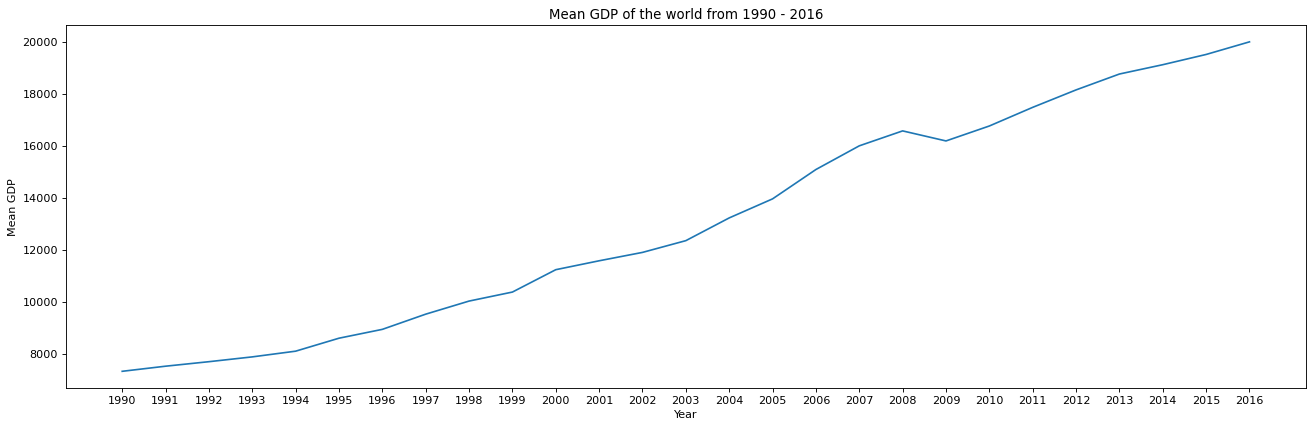

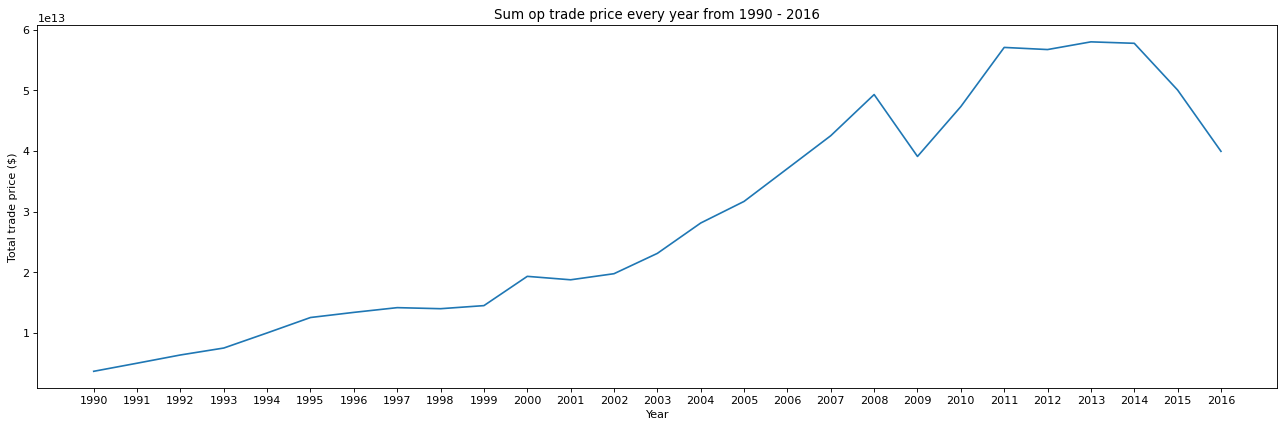

The lowest GDP in the world in 1990: 424.823989 in Ethiopia
The highest GDP in the world in 1990: 72906.52012 in United Arab Emirates
The lowest GDP in the world in 2016: 743.9035976 in Burundi
The highest GDP in the world in 2016: 123573.6308 in Qatar


In [18]:
import findspark
spark_location='C:\spark-3.1.2-bin-hadoop3.2\spark-3.1.2-bin-hadoop3.2\spark-3.1.2-bin-hadoop3.2\spark-3.1.2-bin-hadoop3.2' 
findspark.init(spark_home=spark_location) 
from IPython.display import HTML
import matplotlib.pyplot as plt
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show
from matplotlib.pyplot import figure
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import lower, col

# Creating a spark session.
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

# Loading in dataframes based on a csv.
df_gdp = spark.read.csv("/Users/jordi/Documents/School 2021 - 2022/Data Mining/Datasets/GDP.csv", header=True)
df_trade = spark.read.csv("/Users/jordi/Documents/School 2021 - 2022/Data Mining/Datasets/Trade.csv", header=True)

# Dropping years from the dataframes so that all records in both dataframes have years that are represented in both.
# Certain columns are renamed for usability.
columns_to_drop_gdp = ['2017', '2018', '2019']
df_gdp = df_gdp.drop(*columns_to_drop_gdp)
df_gdp = df_gdp.withColumnRenamed("Country ","Country")

columns_to_drop_trade = ['comm_code', 'quantity_name', 'quantity']
df_trade = df_trade.drop(*columns_to_drop_trade)
df_trade = df_trade.filter(df_trade.year > 1989).filter(df_trade.year < 2017)

# Initialization of list to be used for later calculations.
GDP_means = []
trade_usd_sum_year = []
GDP_extremes = []
GDP_extremes_country = []

# Removing first two colom headers, because they aren't a year.
years = df_gdp.columns
del years[:2]

# For loop used to calculate values that are year based.
for year in years:
    # Price of all trade in a year. This part of the for loop takes up the largest amount of time.
    df_year = df_trade.filter(df_trade.year == year)
    tradeUSD_list = [row[0] for row in df_year.select("trade_usd").collect()]
    tradeUSD_list = [float(i) for i in tradeUSD_list if i]
    trade_usd_sum_year.append(sum(tradeUSD_list))
    
    # Mean GDP every year
    year_list = [row[0] for row in df_gdp.select(year).collect()]
    year_list = [float(i) for i in year_list if i]
    year_mean = sum(year_list) / len(year_list)
    GDP_means.append(year_mean)
    
    # Min and Max GDP for 1990 and 2016
    if (year == years[0] or year == years[-1]):
        year_min = min(year_list)
        year_max = max(year_list)
        GDP_extremes.append((year, year_min, "min"))
        GDP_extremes.append((year, year_max, "max"))
        
df_year.unpersist()
            
#Creating of graphs to get a little feeling of the data. Title of the graphs tells exactly what they represent. 
figure(figsize=(20, 6), dpi=80)
plt.plot(years, GDP_means)
plt.xlabel('Year')
plt.ylabel('Mean GDP')
plt.title('Mean GDP of the world from 1990 - 2016')
plt.show()

figure(figsize=(20, 6), dpi=80)
plt.plot(years, trade_usd_sum_year)
plt.xlabel('Year')
plt.ylabel('Total trade price ($)')
plt.title('Sum op trade price every year from 1990 - 2016')
plt.show()

#Get to know which countries have to highest and lowest GDP at the beginning and end of our GDP dataset.
dfExtremes = df_gdp[['Country', years[0], years[-1]]]
# Find which countries the extreme values belong to
for gdp in GDP_extremes:
    year, gdp_value, extreme = gdp
    result = dfExtremes[dfExtremes[year] == gdp_value]
    country = [(row[0]) for row in result.select("Country").collect()]
    country = ''.join([i for i in country if not i.isdigit()])
    country = country.strip()
    GDP_extremes_country.append((year, gdp_value, extreme, country))
    
dfExtremes.unpersist()
    
print("The lowest GDP in the world in " + GDP_extremes_country[0][0] + ": " + str(GDP_extremes_country[0][1]) + " in " + GDP_extremes_country[0][3])
print("The highest GDP in the world in " + GDP_extremes_country[1][0] + ": " + str(GDP_extremes_country[1][1]) + " in " + GDP_extremes_country[1][3])
print("The lowest GDP in the world in " + GDP_extremes_country[2][0] + ": " + str(GDP_extremes_country[2][1]) + " in " + GDP_extremes_country[2][3])
print("The highest GDP in the world in " + GDP_extremes_country[3][0] + ": " + str(GDP_extremes_country[3][1]) + " in " + GDP_extremes_country[3][3])


In [7]:
#Let a user fill in a country to view gdp and trade info for
form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
    Country : <input type="text" id="country" name="country"><br><br>
    <div>
        <input type="radio" id="trade" name="column" value="trade_usd" checked="checked">
        <label for="html">Total trade per year (USD)</label><br>
    </div>
    <div>
        <input type="radio" id="weight" name="column" value="weight_kg">
        <label for="desc">Total weight of trade per year</label><br>
    </div>
    <div>
        <input id="submit" type="submit" value="Load" onclick="return set_country()">
    </div>
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_country(){
        var var_name1 = 'inp_country';
        var var_name2 = 'inp_column'
        var var_value1 = document.getElementById('country').value;
        var var_value2 = document.getElementById('trade').checked;
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var command2 = var_name2 + " = '" + var_value2 + "'"; 
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        kernel.execute(command2);
        cell1 = IPython.notebook.get_cell(2);
        cell1.execute();
        cell1.focus_cell(2);
    }
</script>
"""

HTML(form + javascript)

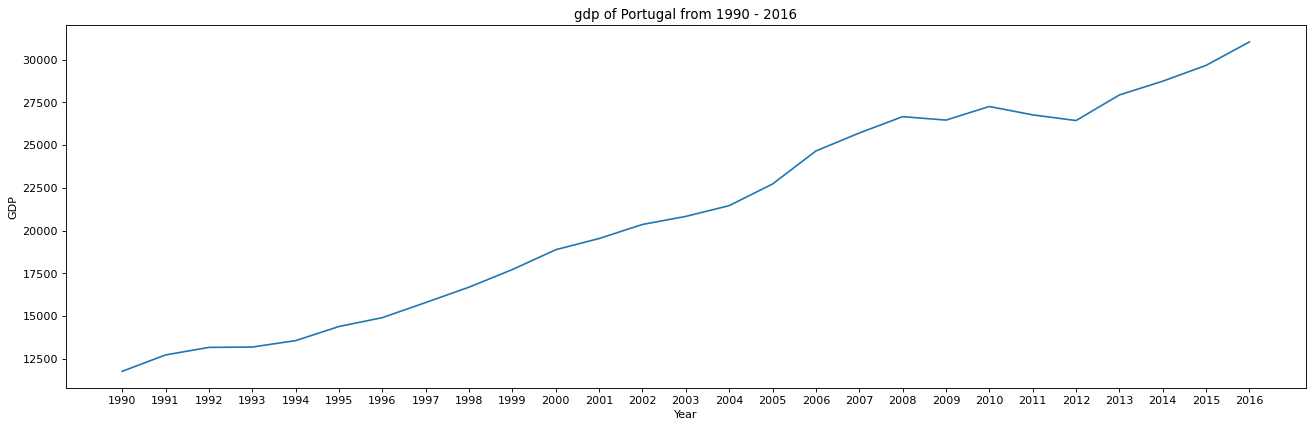

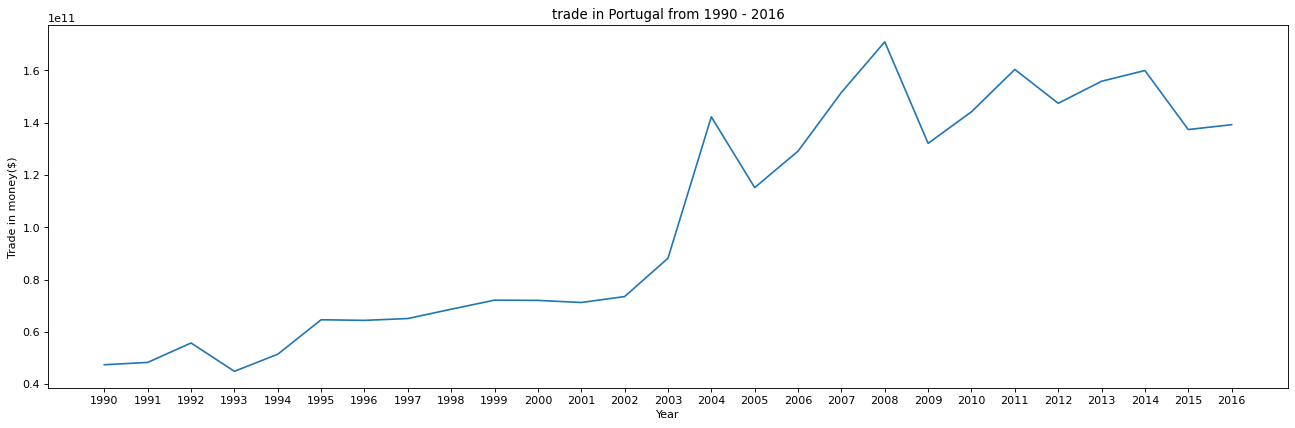

In [20]:
gdp_country = []
country_input = inp_country

df_gdp_country = df_gdp.filter(lower(df_gdp.Country) == country_input.lower())
df_gdp_country = df_gdp_country.drop('Country','Country Code')



# GDP every year for chosen country
for year in years:
    year_gdp = [row[0] for row in df_gdp_country.select(year).collect()]
    year_gdp = [float(i) for i in year_gdp if i]
    gdp_country.append(year_gdp)
    
df_gdp_country.unpersist()

figure(figsize=(20, 6), dpi=80)
plt.plot(years, gdp_country)
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('gdp of ' + country_input + ' from 1990 - 2016')

label=""
column_input = inp_column
trade_country_sum = []

if (column_input == "true"):
    column_input = "trade_usd"
    label = "Trade in money($)"
else :
    column_input = "weight_kg"
    label = "Trade in weight(kg)"
    
df_trade_country = df_trade.select("country_or_area","year",column_input)
df_trade_country = df_trade_country.filter(lower(df_trade_country.country_or_area) == country_input.lower())


# All trade in dollar or weight by country from 1990 - 2016 
for year in years:
    trade_list = df_trade_country.filter(df_trade_country.year == year)
    trade_list = [row[0] for row in trade_list.select(column_input).collect()]
    trade_list = [float(i) for i in trade_list if i]
    trade_country_sum.append(sum(trade_list))

df_trade_country.unpersist()

figure(figsize=(20, 6), dpi=80)
plt.plot(years, trade_country_sum)
plt.xlabel('Year')
plt.ylabel(label)
plt.title('trade in ' + country_input + ' from 1990 - 2016')
plt.show()

In [21]:
#Amount of rows, year and asc, desc should be options for the user to select.
form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
Year : <input id='year' type='range' min='1990' max='2016' step='1' value='2003' onchange='set_vars()'
        oninput="this.nextElementSibling.value = this.value"/>
    <output>2003</output>
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_vars(){
        var var_name1 = 'inp_year';
        var var_value1 = document.getElementById('year').value;
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        cell1 = IPython.notebook.get_cell(4);
        cell2 = IPython.notebook.get_cell(5);
        cell2.clear_output()
        cell1.execute();
        cell1.focus_cell(4);
    }
</script>
"""

HTML(form + javascript)

In [22]:
year_filter = inp_year
#Filter trade by year.
df_trade_year = df_trade.filter(df_trade.year == year_filter)
df_trade_year = df_trade_year.withColumn("trade_usd", df_trade_year["trade_usd"].cast("double"))
df_gdp = df_gdp.withColumn(str(year_filter), df_gdp[year_filter].cast("double"))

#Filter GDP by year.
gdp_year_filter = ["Country", str(year_filter)]
df_gdp_year = df_gdp.select([c for c in df_gdp.columns if c in gdp_year_filter])

#Seperate trade in import and export.
df_trade_export = df_trade_year.filter(df_trade_year.flow.contains('Export'))
df_trade_import = df_trade_year.filter(df_trade_year.flow.contains('Import'))

#Function used to discover which commodity and category (trade) are present the most for each country.
@F.udf
def mode(x):
    from collections import Counter
    return Counter(x).most_common(1)[0][0]

#Start the order by process by specifying which columns to aggregate after the order by on country and region.
cols = ['commodity', 'category']
agg_expr = [mode(F.collect_list(col)).alias(col) for col in cols]
df_trade_export_goods = df_trade_export.groupBy('country_or_area').agg(*agg_expr)
df_trade_import_goods = df_trade_import.groupBy('country_or_area').agg(*agg_expr)

#Join dataframes that contain trade and GDP together. Drop column country because it is a duplicate. Renaming column for 
#year to year_gdp so that it is easier to understand. Done for import and export seperately.
df_trade_export_join = df_trade_export_goods.join(df_gdp_year, df_trade_export_goods.country_or_area == df_gdp_year.Country)
df_trade_export_join = df_trade_export_join.drop("Country")
df_trade_export_join = df_trade_export_join.withColumnRenamed(str(year_filter) ,str(year_filter) + "_gdp")
df_trade_export_join = df_trade_export_join.na.drop()

df_trade_import_join = df_trade_import_goods.join(df_gdp_year, df_trade_import_goods.country_or_area == df_gdp_year.Country)
df_trade_import_join = df_trade_import_join.drop("Country")
df_trade_import_join = df_trade_import_join.withColumnRenamed(str(year_filter) ,str(year_filter) + "_gdp")
df_trade_import_join = df_trade_import_join.na.drop()

form_depiction = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
        Amount of rows to be shown : <input id='rows' type='range' min='1' max='10' step='1' value='5' 
                oninput="this.nextElementSibling.value = this.value"/>
        <output>5</output>
        <div>
            <input type="radio" id="ascending" name="order" value="ascending" checked="checked">
            <label for="html">Show in ascending order</label><br>
        </div>
        <div>
            <input type="radio" id="descending" name="order" value="descending">
            <label for="desc">Show in descending order</label><br>
        </div>
        <div>
            <input id="submit" type="submit" value="Load" onclick="return set_vars_depiction()">
        </div>
</div>     
"""
javascript_depiction = """
<script type="text/Javascript">
    function set_vars_depiction(){
        var var_name1 = 'inp_rows'
        var var_name2 = 'ascending'
        var var_value1 = document.getElementById('rows').value;
        var var_value2 = document.getElementById('ascending').checked;
        var command1 = var_name1 + " = '" + var_value1 + "'"; 
        var command2 = var_name2 + " = '" + var_value2 + "'"; 
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        kernel.execute(command2);
        cell = IPython.notebook.get_cell(5);
        cell.execute();
        cell.focus_cell(3);
    }
</script>
"""
HTML(form_depiction + javascript_depiction)

In [23]:
n_rows = int(inp_rows)
year_col = str(year_filter) + "_gdp"

display(HTML("<style>pre { white-space: pre !important; }</style>"))
#Prints are done to ensure correct values are being used.
if (ascending):
    print("Most common exported commodity and category for the " + str(n_rows) + " lowest ranked gdp countries")
    df_trade_export_join.sort(df_trade_export_join[year_col].asc()).show(n_rows, truncate = False)
    print("Most common imported commodity and category for the " + str(n_rows) + " lowest ranked gdp countries")
    df_trade_import_join.sort(df_trade_import_join[year_col].asc()).show(n_rows, truncate = False)
else :
    print("Most common exported commodity and category for the " + str(n_rows) + " highest ranked gdp countries")
    df_trade_export_join.sort(df_trade_export_join[year_col].desc()).show(n_rows, truncate = False)
    print("Most common imported commodity and category for the " + str(n_rows) + " highest ranked gdp countries")
    df_trade_import_join.sort(df_trade_import_join[year_col].desc()).show(n_rows, truncate = False)
    
    
df_trade_export.unpersist()
df_trade_export_join.unpersist()
df_trade_import.unpersist()
df_trade_import_join.unpersist()
df_trade_export_goods.unpersist()
df_trade_import_goods.unpersist()
df_gdp_year.unpersist()



Most common exported commodity and category for the 6 lowest ranked gdp countries
+---------------+-----------------------------------------------------+------------------------------------------------------+-----------+
|country_or_area|commodity                                            |category                                              |2007_gdp   |
+---------------+-----------------------------------------------------+------------------------------------------------------+-----------+
|Burundi        |Ornamental fish, live                                |87_vehicles_other_than_railway_tramway                |666.8755949|
|Niger          |Milk not concentrated nor sweetened < 1% fat         |41_raw_hides_and_skins_other_than_furskins_and_leather|728.0355856|
|Ethiopia       |Bovine carcasses and half carcasses, fresh or chilled|07_edible_vegetables_and_certain_roots_and_tubers     |811.0642774|
|Mozambique     |Milk not concentrated nor sweetened 1-6% fat         |12_oil_seed_o

DataFrame[Country: string, 2007: double]